In [14]:
import pygplates
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import xarray as xr

import paleogeography as pg
reload(pg)

%matplotlib inline



basedir = '/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles/'

time = 126  #195 #76.
sampling = 1.0

rotation_model = pygplates.RotationModel(['%s/Global_EB_250-0Ma_GK07_Matthews++.rot' % basedir,
                                          '%s/Global_EB_410-250Ma_GK07_Matthews++.rot' % basedir])

pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (basedir,time)



In [15]:
env_list = ['lm','m','sm','i']

pg_features = pg.load_paleogeography(pg_dir,env_list)

pg_reconstructed = []
pygplates.reconstruct(pg_features,rotation_model,pg_reconstructed,time)


['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/lm_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/sm_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
[]
no features of type i


In [16]:
# This was an abandoned attempt to clean up the extracted paleoshorelines from
# 
def distance_to_shoreline(pg_reconstructed):
    pShoreline = []
    pLon = []
    pLat = []

    for feature in pg_reconstructed:
        if feature.get_feature().get_shapefile_attribute('Layer') == 'lm':
            print 'working on feature....'
            tessellated_boundary = feature.get_reconstructed_geometry().to_tessellated(np.radians(5.0))

            for point in tessellated_boundary.get_points():

                min_distance_to_features = None

                for feature2 in pg_reconstructed: 
                    if feature2.get_feature().get_shapefile_attribute('Layer') == 'sm':
                        for polygon2 in feature2.get_reconstructed_geometry():

                            distance_to_feature = pygplates.GeometryOnSphere.distance(point,
                                                                                      polygon2,
                                                                                      min_distance_to_features)

                            if distance_to_feature is not None:
                                min_distance_to_features = distance_to_feature

                #if min_distance_to_features < np.radians(0.05):
                pShoreline.append(min_distance_to_features)
                #else:
                    #pShoreline.append(0.)
                pLon.append(point.to_lat_lon()[1])
                pLat.append(point.to_lat_lon()[0])
                                                    


['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/lm_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
[]
no features of type i


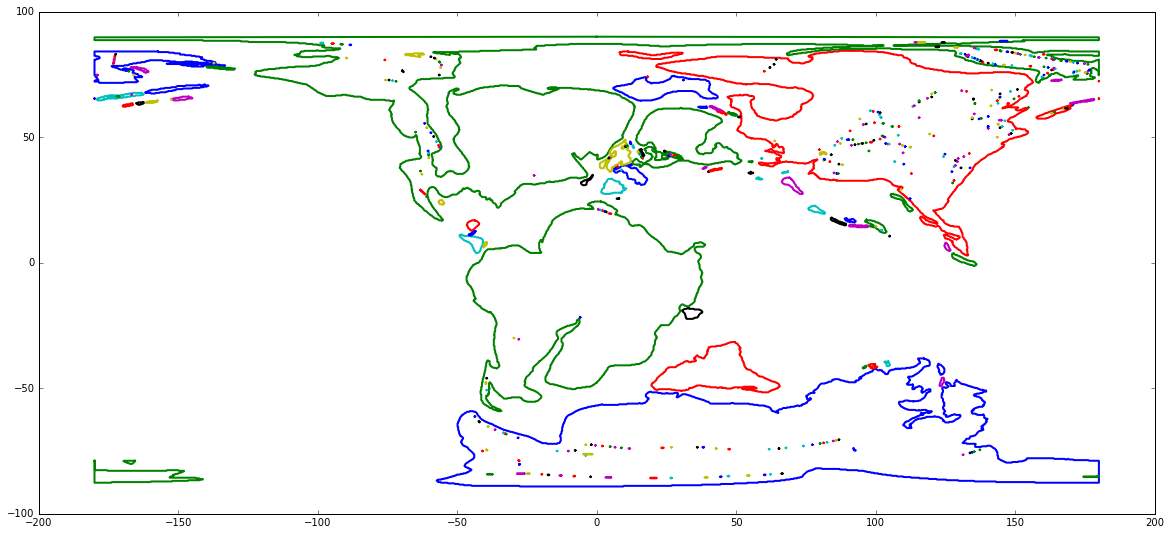

In [4]:
import polygon_processing as pp
reload(pp)

env_list = ['lm','m','i']
pg_features = pg.load_paleogeography(pg_dir,env_list)


cf = pp.merge_polygons(pg_features,rotation_model,time=time,sampling=0.25)

plt.figure(figsize=(20,9))
for n, contour in enumerate(cf):
    plt.plot(contour.get_geometry().to_lat_lon_array()[:, 1], 
             contour.get_geometry().to_lat_lon_array()[:, 0], linewidth=2)


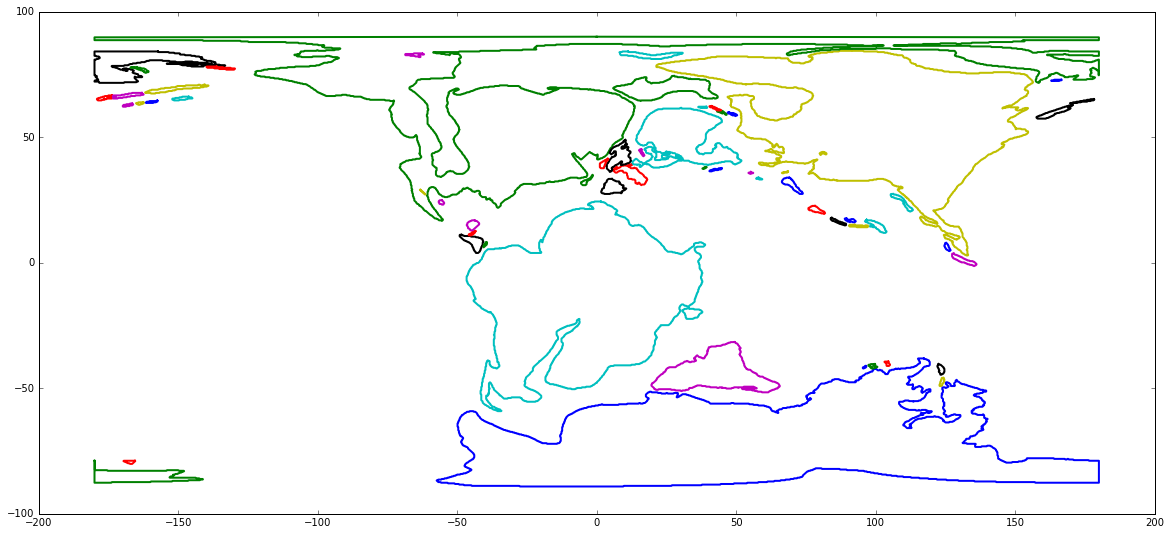

In [5]:
area_threshold = 0.0001

sieve_polygons = pp.polygon_area_threshold(cf,area_threshold)

plt.figure(figsize=(20,9))
for n, contour in enumerate(sieve_polygons):
    plt.plot(contour.get_geometry().to_lat_lon_array()[:, 1], 
             contour.get_geometry().to_lat_lon_array()[:, 0], linewidth=2)
    
pygplates.FeatureCollection(sieve_polygons).write('Paleoshoreline_255.gpmlz')

In [11]:
static_polygons = '/Applications/GPlates-2.0.0/SampleData/FeatureCollections/ContinentalPolygons/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz'

(cc_features,
 uncc_features) = pygplates.partition_into_plates(static_polygons,
                                              rotation_model,
                                              sieve_polygons,
                                              reconstruction_time=time,
                                              #partition_method=pygplates.PartitionMethod.most_overlapping_plate, #PartitionMethod.split_into_plates,
                                              sort_partitioning_plates=pygplates.SortPartitioningPlates.by_plate_area,
                                              partition_return = pygplates.PartitionReturn.separate_partitioned_and_unpartitioned)


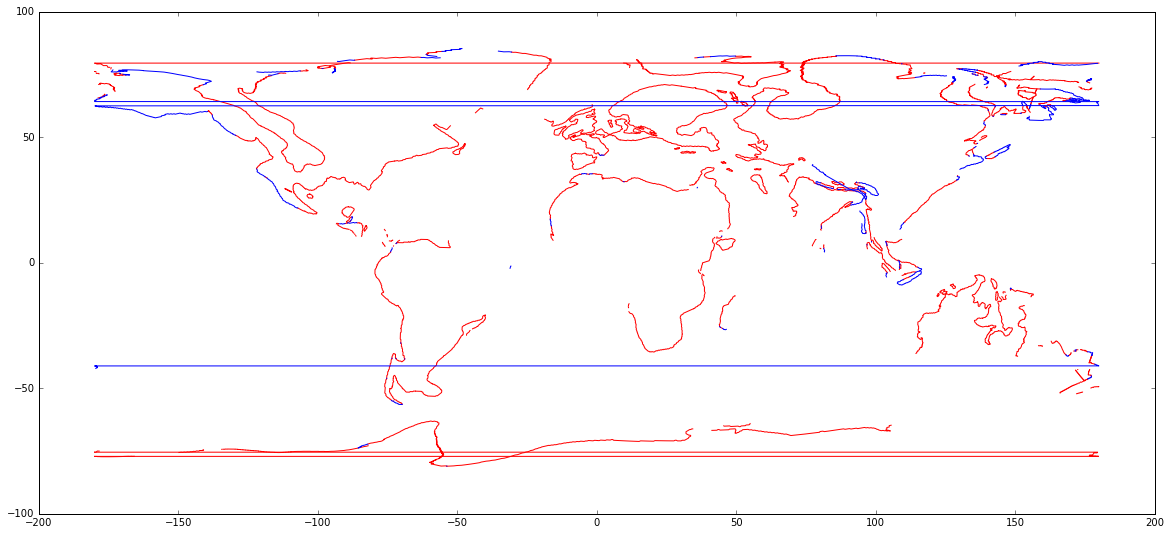

In [28]:
plt.figure(figsize=(20,9))

for feature in cc_features:
    #print feature.get_reconstruction_plate_id()
    if feature.get_reconstruction_plate_id() != 0:
        for geometry in feature.get_geometries():
            #print geometry
            if geometry is not None:
                plt.plot(geometry.to_lat_lon_array()[:,1],
                         geometry.to_lat_lon_array()[:,0],
                         color='red')

                
reconstructed_static_polygons = []
pygplates.reconstruct(static_polygons,rotation_model,reconstructed_static_polygons,time)
 
distance_threshold_radians = 20./pygplates.Earth.mean_radius_in_kms

cc_by_proximity_features = []
for feature in uncc_features:
    #print feature.get_reconstruction_plate_id()
    if feature.get_reconstruction_plate_id() == 0:
        
        min_distance_to_all_reconstructed_static_polygon = distance_threshold_radians
        nearest_reconstructed_static_polygon = None 
        
        for geometry in feature.get_geometries():
            
            for polygon in reconstructed_static_polygons:
            
                min_distance_to_feature = pygplates.GeometryOnSphere.distance(
                    geometry,
                    polygon.get_reconstructed_geometry(),
                    distance_threshold_radians = min_distance_to_all_reconstructed_static_polygon)

                # A minimum distance of zero means the current reconstructed geometry either
                # intersects the polygon's boundary or is inside it (or both).
                if min_distance_to_feature is not None:
                    min_distance_to_all_reconstructed_static_polygon = min_distance_to_feature
                    nearest_reconstructed_static_polygon = polygon.get_feature().get_reconstruction_plate_id()
                                    
            if nearest_reconstructed_static_polygon is not None:
                new_feature = feature.clone()
                new_feature.set_geometry(geometry)
                new_feature.set_reconstruction_plate_id(nearest_reconstructed_static_polygon)
                cc_by_proximity_features.append(new_feature)

pygplates.reverse_reconstruct(cc_by_proximity_features,rotation_model,time)
                
for feature in cc_by_proximity_features:
    #print feature.get_reconstruction_plate_id()
    if feature.get_reconstruction_plate_id() != 0:
        for geometry in feature.get_geometries():
            #print geometry
            if geometry is not None:
                plt.plot(geometry.to_lat_lon_array()[:,1],
                         geometry.to_lat_lon_array()[:,0],
                         color='blue')
        

pygplates.FeatureCollection(cc_features+cc_by_proximity_features).write('tmp_psl.gpmlz')
        

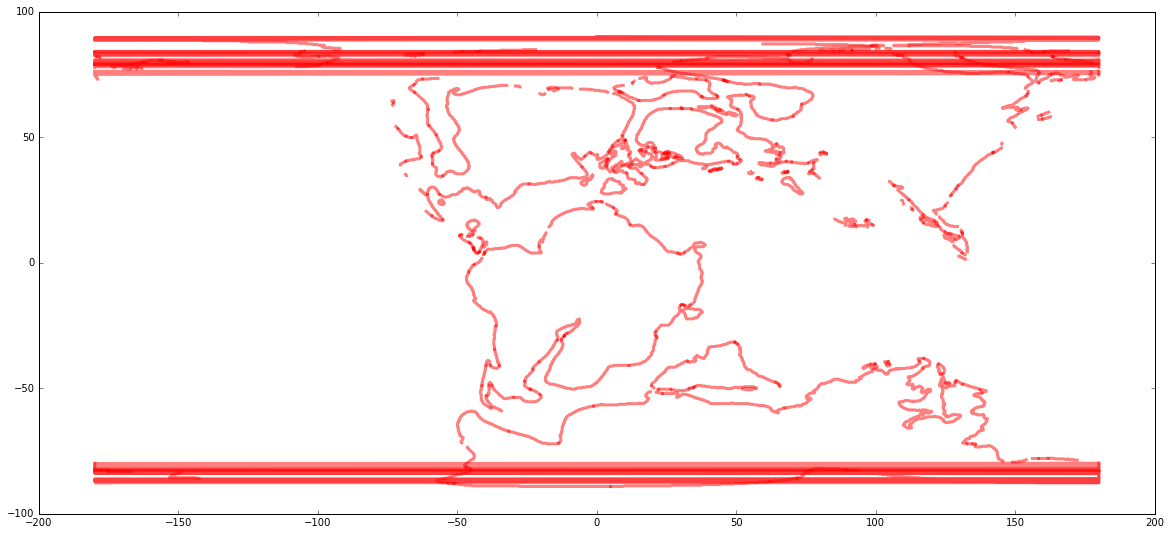

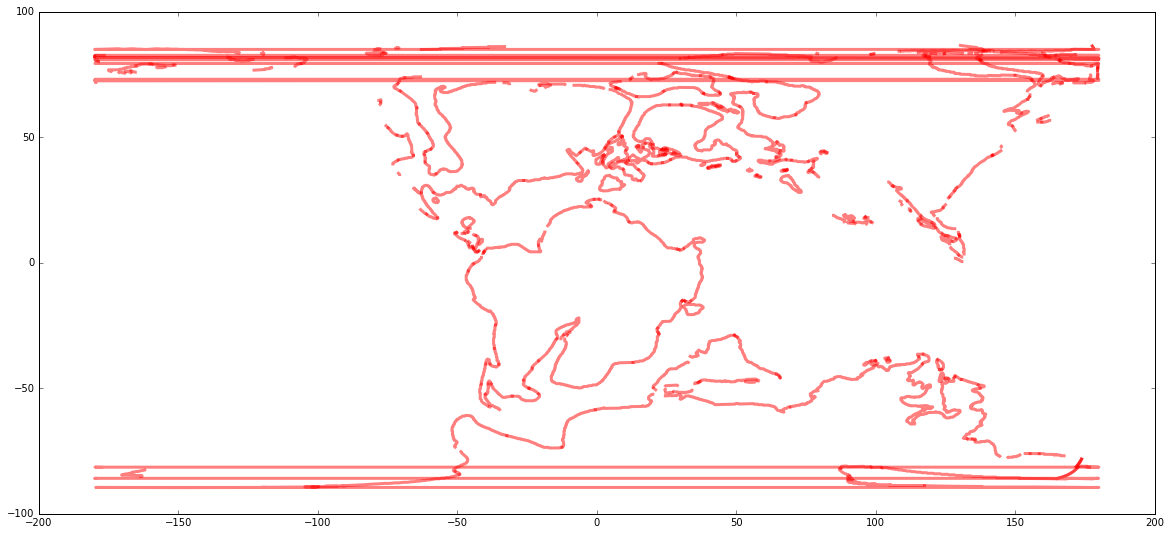

In [30]:
rcc_features = []
pygplates.reconstruct(cc_features,rotation_model,rcc_features,time)

plt.figure(figsize=(20,9))
for feature in rcc_features:
    #print feature.get_reconstruction_plate_id()
    if feature.get_feature().get_reconstruction_plate_id() != 0:
        geometry = feature.get_reconstructed_geometry()
        #print geometry
        if geometry is not None:
            plt.plot(geometry.to_lat_lon_array()[:,1],
                     geometry.to_lat_lon_array()[:,0],
                     linewidth=3,color='red',alpha=0.5)
    else:
        geometry = feature.get_reconstructed_geometry()
        #print geometry
        if geometry is not None:
            plt.plot(geometry.to_lat_lon_array()[:,1],
                     geometry.to_lat_lon_array()[:,0],
                     linewidth=3,color='blue',alpha=0.5)
        
rcc_features = []
pygplates.reconstruct(cc_features,rotation_model,rcc_features,time-5)

plt.figure(figsize=(20,9))
for feature in rcc_features:
    #print feature.get_reconstruction_plate_id()
    if feature.get_feature().get_reconstruction_plate_id() != 0:
        geometry = feature.get_reconstructed_geometry()
        #print geometry
        if geometry is not None:
            plt.plot(geometry.to_lat_lon_array()[:,1],
                     geometry.to_lat_lon_array()[:,0],
                     linewidth=3,color='red',alpha=0.5)        
    else:
        geometry = feature.get_reconstructed_geometry()
        #print geometry
        if geometry is not None:
            plt.plot(geometry.to_lat_lon_array()[:,1],
                     geometry.to_lat_lon_array()[:,0],
                     linewidth=3,color='blue',alpha=0.5)
            

['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/lm_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_105Ma/m_fig48_117_94_PresentDay_Paleogeog_Matthews2016_105.00Ma.shp']
[]
no features of type i
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/lm_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']
[]
no features of type i


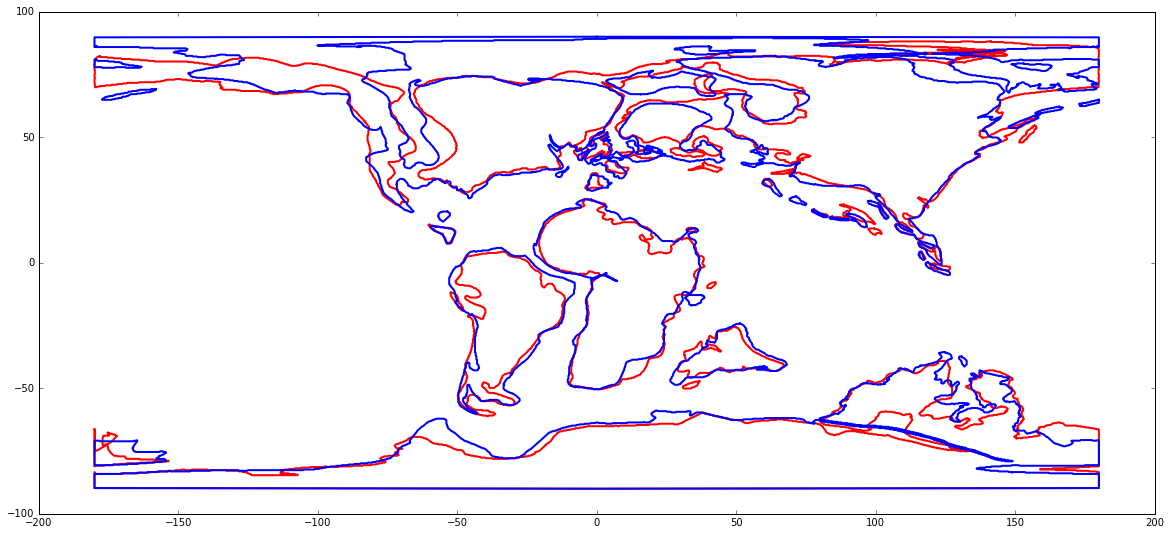

In [118]:
area_threshold = 0.001
env_list = ['lm','m','i']

t1 = 105.
t2 = 126.

pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (basedir,t1)

pg_features = pg.load_paleogeography(pg_dir,env_list)
cf = pp.merge_polygons(pg_features,rotation_model,time=t1,sampling=0.25)
sieve_polygons_t1 = pp.polygon_area_threshold(cf,area_threshold)

pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (basedir,t2)

pg_features = pg.load_paleogeography(pg_dir,env_list)
#cf2 = []
for f in pg_features:
    f.set_valid_time(9999,-9999)
    #cf2.append(f)
cf = pp.merge_polygons(pg_features,rotation_model,time=t1,sampling=0.25)

sieve_polygons_t2 = pp.polygon_area_threshold(cf,area_threshold)


plt.figure(figsize=(20,9))
for n, contour in enumerate(sieve_polygons_t1):
    plt.plot(contour.get_geometry().to_lat_lon_array()[:, 1], 
             contour.get_geometry().to_lat_lon_array()[:, 0], linewidth=2,color='red')
    
for n, contour in enumerate(sieve_polygons_t2):
    plt.plot(contour.get_geometry().to_lat_lon_array()[:, 1], 
             contour.get_geometry().to_lat_lon_array()[:, 0], linewidth=2,color='blue')



In [133]:
import points_spatial_tree
from polygon_processing import run_grid_pnp

# function to run point in/near polygon test for two successive time slices
def interpolate_paleoshoreline_for_stage(pg_features_t1,t1,t2,psl_t1,psl_t2,time_step,points,
                                         spatial_tree_of_uniform_recon_points,rotation_model,plot=False):
    
    print 'Working on interpolation from %0.2f Ma to %0.2f Ma .....' % (t1,t2)
    
    plate_partitioner = pygplates.PlatePartitioner(pg_features, rotation_model, reconstruction_time=t1)
    
    
    distance_to_land_t1,distance_to_psl_t1 = run_grid_pnp(t1,
                                                          points,
                                                          spatial_tree_of_uniform_recon_points,
                                                          psl_t1,
                                                          rotation_model)
    
    distance_to_land_t2,distance_to_psl_t2 = run_grid_pnp(t1,
                                                          points,
                                                          spatial_tree_of_uniform_recon_points,
                                                          psl_t2, 
                                                          rotation_model)
    
    # this mask is true where one (and only one) of the indicators is not zero
    # --> delineates points that change environment between time steps
    #msk = np.logical_xor(distance_to_land_t1,distance_to_land_t2)
    
    regression_msk = np.logical_and(distance_to_land_t1==0,distance_to_land_t2>0)
    
    transgression_msk = np.logical_and(distance_to_land_t1>0,distance_to_land_t2==0)
    
    always_land_msk = np.logical_and(distance_to_land_t1==0,distance_to_land_t2==0)

    # normalised distance derivation
    # for each point, divide the distance to shoreline at t0 by the total distance to both shorelines
    # --> if the point is halfway between the shorelines, value will be 0.5
    #     if the point is closer to the t1 shoreline, the value will be less than 0.5
    #     all values will be between 0 and 1
    psl_dist_norm = np.divide(distance_to_psl_t1,(distance_to_psl_t1+distance_to_psl_t2))

    
    t_diff = (t2-t1)
    
    
    coords = zip(*[point.to_lat_lon() for point in points])
    plt.figure(figsize=(20,9))
    plt.scatter(np.array(coords[1]),np.array(coords[0]),c=distance_to_land_t1,
                edgecolors='',s=2,alpha=0.5,vmin=0.,vmax=0.1)
    #plt.plot(np.array(coords[1])[transgression_msk],np.array(coords[0])[transgression_msk],'b.',markersize=3,alpha=0.3)
    #plt.plot(np.array(coords[1])[regression_msk],np.array(coords[0])[regression_msk],'r.',markersize=3,alpha=0.3)
    plt.title('%0.2f - %0.2f Ma' % (t1,t2))
    plt.colorbar()
    plt.show()
    
    coords = zip(*[point.to_lat_lon() for point in points])
    plt.figure(figsize=(20,9))
    plt.scatter(np.array(coords[1]),np.array(coords[0]),c=distance_to_psl_t1,
                edgecolors='',s=2,alpha=0.5,vmin=0.,vmax=0.1)
    #plt.plot(np.array(coords[1])[transgression_msk],np.array(coords[0])[transgression_msk],'b.',markersize=3,alpha=0.3)
    #plt.plot(np.array(coords[1])[regression_msk],np.array(coords[0])[regression_msk],'r.',markersize=3,alpha=0.3)
    plt.title('%0.2f - %0.2f Ma' % (t1,t2))
    plt.colorbar()
    plt.show()
    
    coords = zip(*[point.to_lat_lon() for point in points])
    plt.figure(figsize=(20,9))
    plt.scatter(np.array(coords[1]),np.array(coords[0]),c=distance_to_land_t2,
                edgecolors='',s=2,alpha=0.5,vmin=0.,vmax=0.1)
    #plt.plot(np.array(coords[1])[transgression_msk],np.array(coords[0])[transgression_msk],'b.',markersize=3,alpha=0.3)
    #plt.plot(np.array(coords[1])[regression_msk],np.array(coords[0])[regression_msk],'r.',markersize=3,alpha=0.3)
    plt.title('%0.2f - %0.2f Ma' % (t1,t2))
    plt.colorbar()
    plt.show()
    
    coords = zip(*[point.to_lat_lon() for point in points])
    plt.figure(figsize=(20,9))
    plt.scatter(np.array(coords[1]),np.array(coords[0]),c=distance_to_psl_t2,
                edgecolors='',s=2,alpha=0.5,vmin=0.,vmax=0.1)
    #plt.plot(np.array(coords[1])[transgression_msk],np.array(coords[0])[transgression_msk],'b.',markersize=3,alpha=0.3)
    #plt.plot(np.array(coords[1])[regression_msk],np.array(coords[0])[regression_msk],'r.',markersize=3,alpha=0.3)
    plt.title('%0.2f - %0.2f Ma' % (t1,t2))
    plt.colorbar()
    plt.show()
    
    
    pg_points_land_list = []
    
    # don't need to do t2 itself, since this will be first step in next iteration
    for reconstruction_time in np.arange(t1,t2,time_step):
        
        if reconstruction_time==t1:
            land_points = np.where(distance_to_land_t1==0)[0]
            print land_points.shape
        else:
            t_norm = (reconstruction_time-t1)/t_diff
            #land_points = np.where(t_norm)
            is_transgressing_land_msk = np.less_equal(psl_dist_norm,t_norm)
            
            is_regressing_land_msk = np.greater_equal(psl_dist_norm,t_norm)
            
            land_points = np.where(
                np.logical_or(
                    np.logical_or(
                        np.logical_and(is_regressing_land_msk,regression_msk),
                        np.logical_and(is_transgressing_land_msk,transgression_msk)
                    ),
                always_land_msk))[0]
            
            print t_norm

        if plot:
            
            plt.figure(figsize=(20,9))
            coords = zip(*[point.to_lat_lon() for point in points])
            #plt.plot(np.array(coords[1])[always_land_msk],np.array(coords[0])[always_land_msk],'k.',markersize=3,alpha=0.3)
            plt.plot(np.array(coords[1])[land_points],np.array(coords[0])[land_points],'k.',markersize=3,alpha=0.3)
            #plt.scatter(np.array(coords[1])[land_points],np.array(coords[0])[land_points],
            #        c=psl_dist_norm,edgecolors='',s=2)
            #plt.colorbar()
            plt.title('%0.2fMa' % reconstruction_time)
            plt.xlim(-180.,180.)
            plt.ylim(-90.,90.)
            plt.savefig('./tmp/interpolated_psl_%0.2fMa.png' % reconstruction_time)
            plt.close()
            


        coords = zip(*[point.to_lat_lon() for point in points])
        plt.figure()
        plt.plot(np.array(coords[1])[land_points],np.array(coords[0])[land_points],'k.',markersize=3,alpha=0.3)

        #print land_points
        #print np.array(coords[1])[land_points],np.array(coords[0])[land_points]
        #print zip(np.array(coords[1])[land_points],np.array(coords[0])[land_points])
        tmp = pygplates.MultiPointOnSphere(zip(np.array(coords[0])[land_points],np.array(coords[1])[land_points]))
        tmpp = pygplates.Feature()
        tmpp.set_geometry(tmp)
        
        (pg_points_land,
         pg_points_ocean) = plate_partitioner.partition_features(tmpp,
                                                                 partition_return = pygplates.PartitionReturn.separate_partitioned_and_unpartitioned)
        plt.figure()
        for feature in pg_points_land:
            for geometry in feature.get_geometries():
                plt.plot(geometry.to_lat_lon_array()[:,1],
                         geometry.to_lat_lon_array()[:,0],'.',color='red',markersize=3)
        plt.show()
        
        for feature in pg_points_land:
            feature.set_valid_time(reconstruction_time+(time_step/2.),
                                   reconstruction_time-(time_step/2.))
        
        pg_points_land_list+=pg_points_land
    
    pygplates.FeatureCollection(pg_points_land_list).write('tweentest_%0.2fMa_%0.2fMa.gpmlz' % (t1,t2))




['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/lm_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/i_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_90Ma/lm_fig50_94_81_PresentDay_Paleogeog_Matthews2016_90.00Ma.shp']
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthew

/Users/Simon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in divide


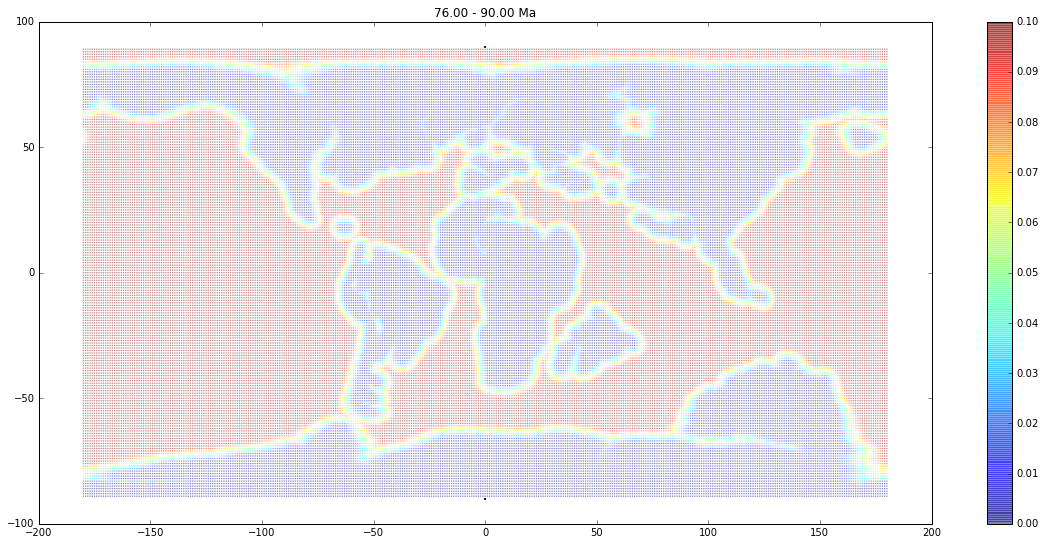

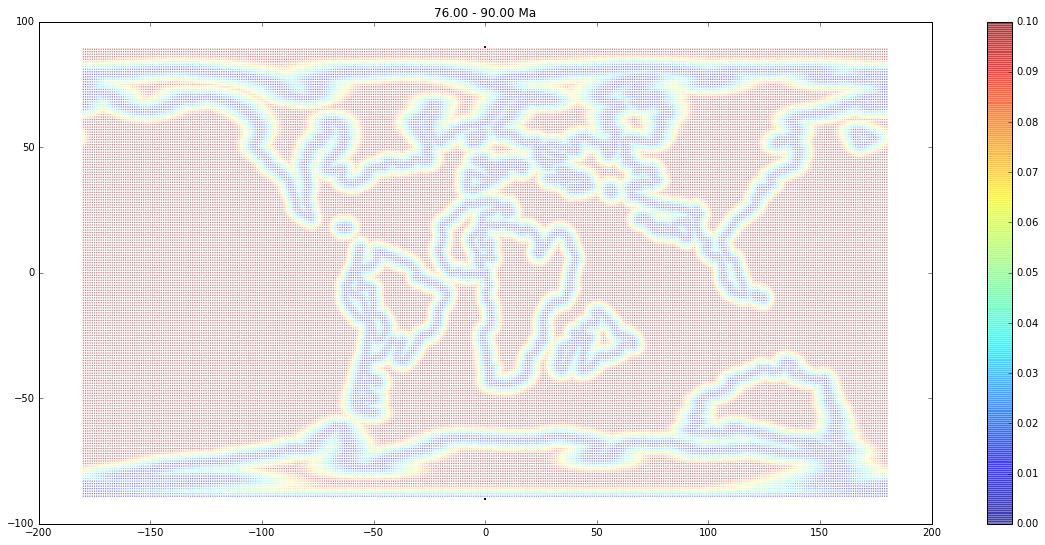

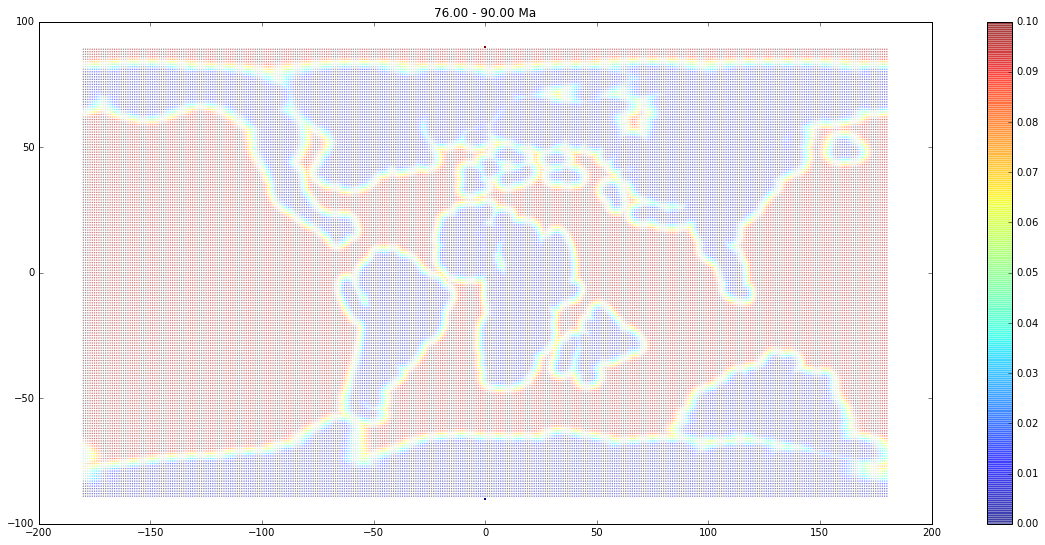

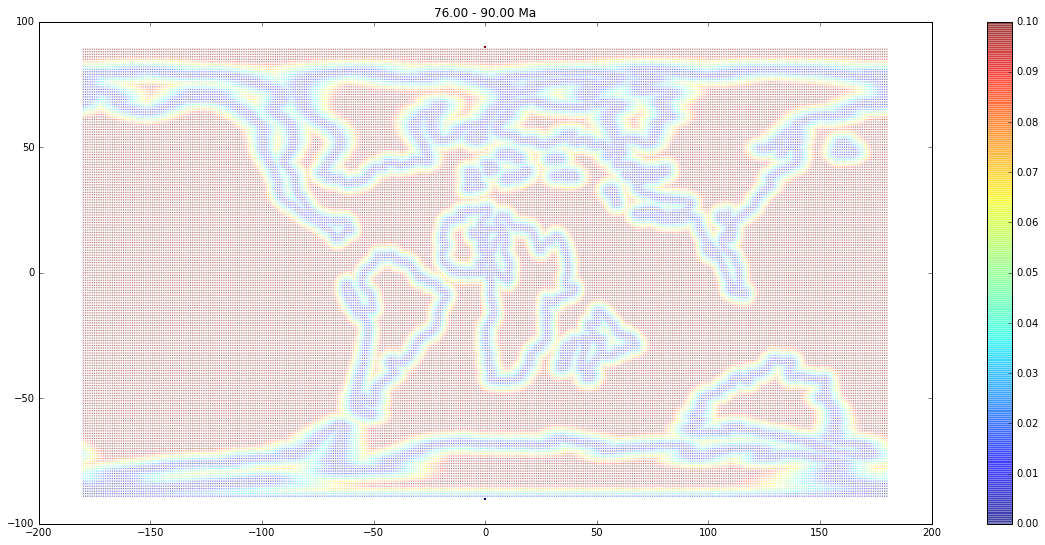

(21698,)


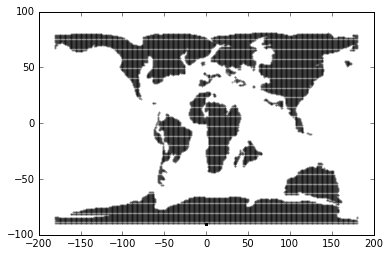

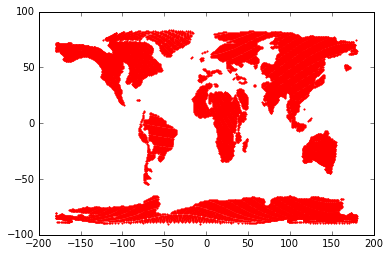

0.0714285714286


/Users/Simon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:98: RuntimeWarning: invalid value encountered in less_equal
/Users/Simon/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:100: RuntimeWarning: invalid value encountered in greater_equal


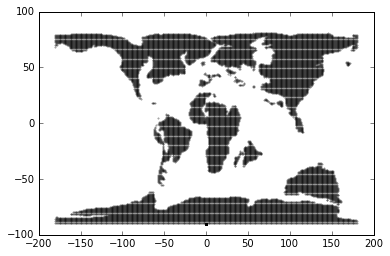

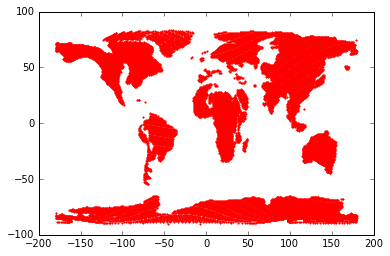

0.142857142857


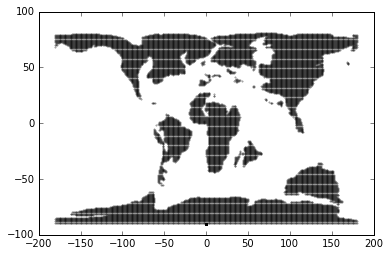

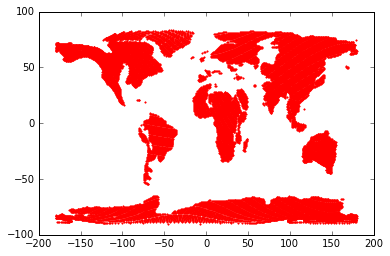

0.214285714286


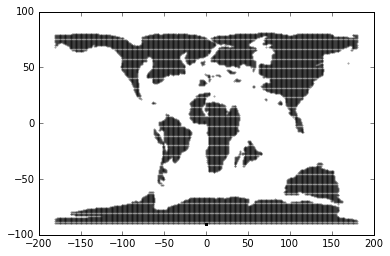

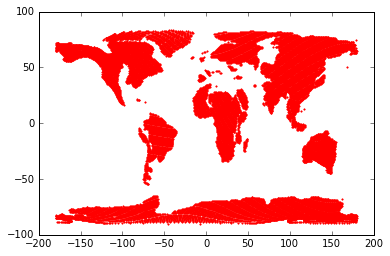

0.285714285714


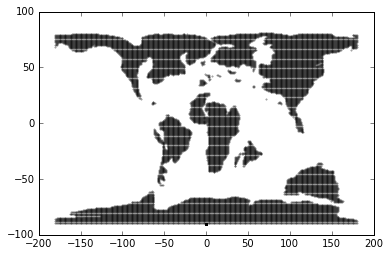

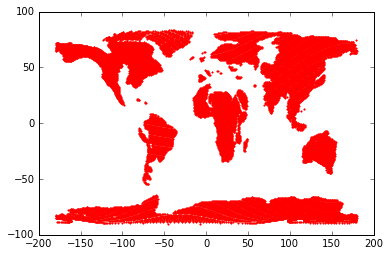

0.357142857143


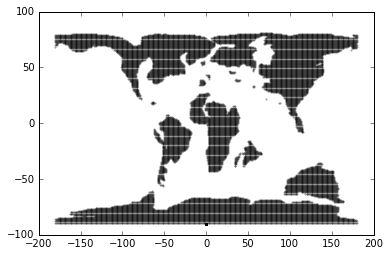

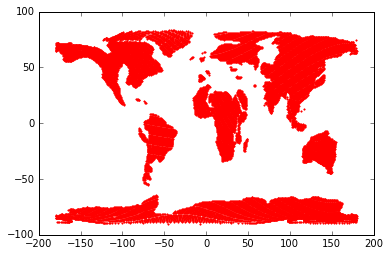

0.428571428571


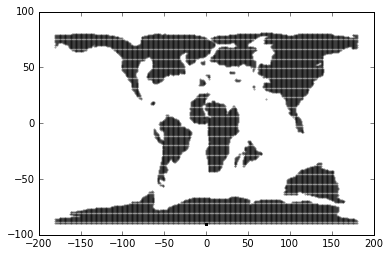

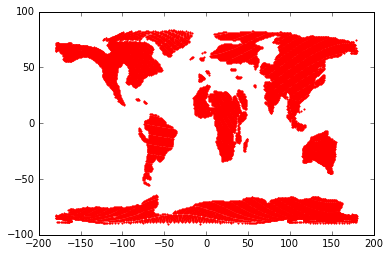

0.5


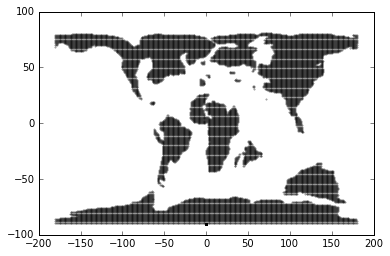

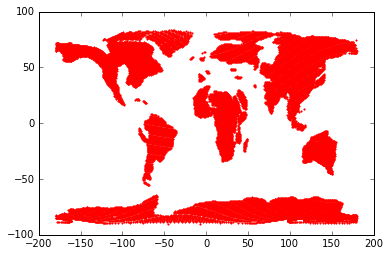

0.571428571429


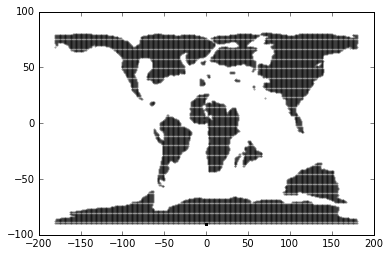

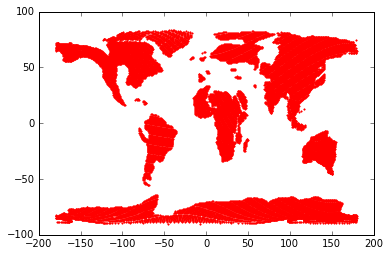

0.642857142857


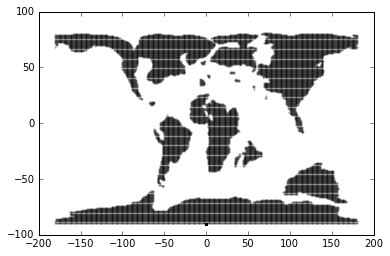

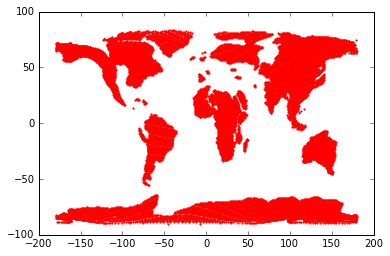

0.714285714286


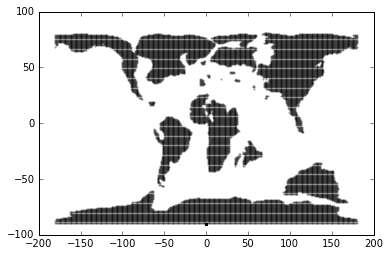

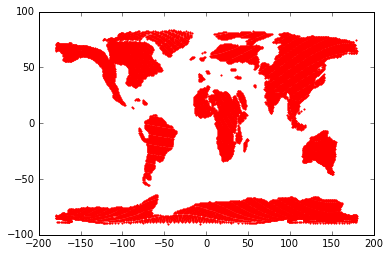

0.785714285714


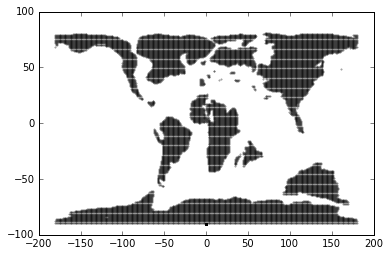

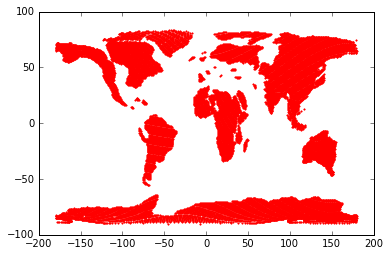

0.857142857143


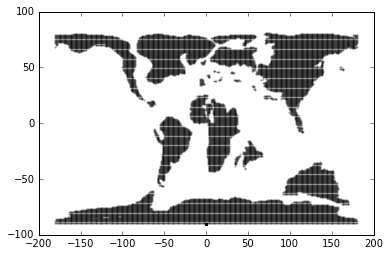

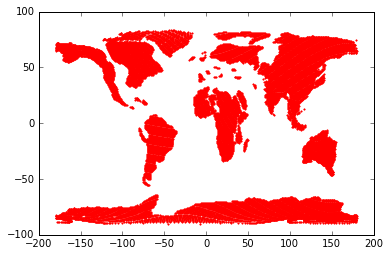

0.928571428571


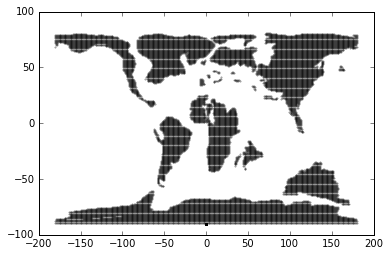

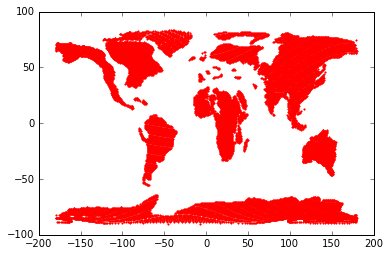

In [137]:
area_threshold = 0.001
env_list = ['lm','m','i']

t1 = 76.
t2 = 90.

pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (basedir,t1)

pg_features = pg.load_paleogeography(pg_dir,env_list)
cf = pp.merge_polygons(pg_features,rotation_model,time=t1,sampling=0.25)
sieve_polygons_t1 = pp.polygon_area_threshold(cf,area_threshold)

pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (basedir,t2)

pg_features = pg.load_paleogeography(pg_dir,env_list)
#cf2 = []
for f in pg_features:
    f.set_valid_time(9999,-9999)
    #cf2.append(f)
cf = pp.merge_polygons(pg_features,rotation_model,time=t1,sampling=0.25)

sieve_polygons_t2 = pp.polygon_area_threshold(cf,area_threshold)



pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (basedir,t1)
env_list = ['lm','m','i','sm']
pg_features = pg.load_paleogeography(pg_dir,env_list)


lons,lats = np.meshgrid(np.arange(-180,180+sampling,sampling),np.arange(-90,90+sampling,sampling))
points = [pygplates.PointOnSphere(lat, lon) for lat, lon in zip(lats.flatten(),lons.flatten())]

spatial_tree_of_uniform_recon_points = points_spatial_tree.PointsSpatialTree(points)

time_step = 1
interpolate_paleoshoreline_for_stage(pg_features,t1,t2,sieve_polygons_t1,sieve_polygons_t2,time_step,points,
                                     spatial_tree_of_uniform_recon_points,rotation_model,plot=True)

